# Mathematical optimization of ETFs and cash
How do you find the best mixing ratio of ETFs and cash in asset management? Let's make python do the job for you.

In [2]:
import pandas as pd
from pandas_datareader.stooq import StooqDailyReader
from datetime import datetime

In [6]:
def fetch_data_5years(brand):
    # fetch 5 years of stock price data 
    start = datetime(2017, 1, 1)
    end = datetime(2021, 12, 31)

    stooq = StooqDailyReader(brand, start=start, end=end)
    data = stooq.read()
    return data

In [7]:
# 1306.JP TOPIX上場型投資信託
# TOK iShares MSCI KOKUSAI Index
# 1326.JP SPDRゴールド・シェア
etfs = [fetch_data_5years(brand) for brand in ['1306.JP', 'TOK', '1326.JP']]

In [36]:
# remove the dates which weren't in other dataframes
# set of dates for each dataframe
etfs_set = [set(etfs[i].index) for i in range(3)]
# set of overlapping dates
dates_overlap = etfs_set[0] & etfs_set[1] & etfs_set[2]
# align dates
etfs = [etf[etf.index.isin(dates_overlap)] for etf in etfs]

# Solve

In [54]:
import pulp # mathematical optimization library

# initialization
prob = pulp.LpProblem('stock_porfolio', # name of the problem
                      pulp.LpMaximize) # maximize the target variable

# mixing ratio of ETFs
ratios_etf = [pulp.LpVariable(f'ratio_{brand}', 
                    lowBound = 0,
                    upBound=1,
                    cat=pulp.LpContinuous
                    ) for brand in ['topix', 'ishares', 'gold']]

# mixing ratio of cash
ratio_cash = pulp.LpVariable(f'cash_ratio', 
                    lowBound = 0,
                    upBound=1,
                    cat=pulp.LpContinuous
                    )

# dollar cost averaging over 7 days
stocks = [pulp.lpSum((1 / (7 * etf.Close.tail(7))) * ratio)
          for etf, ratio in zip(etfs, ratios_etf)]

# The objective variable is the total price of the assets at the last day of 2017
prob += sum([stock * etf['2017-12-31':'2017-01-01'].Close[0] for stock, etf in zip(stocks, etfs)]) + ratio_cash
# The sum of the total ratios should be 1
prob += sum([ratio for ratio in ratios_etf]) + ratio_cash <= 1
status = prob.solve()
print("Status", pulp.LpStatus[status])

Status Optimal


# Result

In [59]:
for ratio in ratios_etf:
    print(ratio, ratio.value())
print('cash', ratio_cash.value())

print('object_value', prob.objective.value())

ratio_topix 1.0000889e-12
ratio_ishares 1.0
ratio_gold 0.0
cash 0.0
object_value 1.1916809953090282


# Simulation using the result

In [61]:
etfs_4y = [etf['2021-12-31':'2018-01-01'] for etf in etfs]

<AxesSubplot:xlabel='Date'>

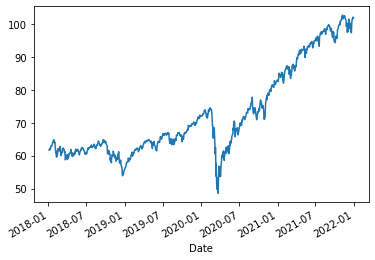

In [66]:
simulation = sum([etf.Close * ratio.value() for etf, ratio in zip(etfs_4y, ratios_etf)]) + ratio_cash.value()
simulation.plot()